In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet('./data/data_df_hcm.parquet')
target_df = pd.read_parquet('./data/target_df_hcm.parquet')


In [3]:
df

,nearest_5_district,nearest_8_street,nearest_2_ward,nearest_4_district,nearest_1_district,typeOfRealEstate,houseDirection,nearest_5_street,nearest_7_street,street,...,distance_hn_CongtruongLamSon,distance_hn_DuongNguyenHuequan1TPHCM,nearest_4_lat,num_of_atm_in_2000m_radius,num_of_place_of_worship_in_2000m_radius,num_of_restaurant_in_1000m_radius,numberOfBathRooms,distance_hn_DuongNamKyKhoiNghia,event_timestamp,realestate_id
24794,11,1730,13,11,11,3,0,857,756,253,...,7.647704,7.771465,10.790462,106,98,97,4.478184,7.835349,2023-04-01,24794
37176,10,2986,547,10,10,3,0,4053,3429,493,...,8.551525,8.572820,10.786360,35,72,15,4.478184,8.578963,2023-04-03,37176
6905,11,100,518,11,11,3,0,495,100,2252,...,7.143411,6.899570,10.766617,129,109,303,4.478184,6.688504,2023-05-18,6905
6412,10,3640,438,14,14,0,1,3062,1479,1551,...,8.428535,8.488024,10.803249,58,48,13,2.000000,8.519420,2023-07-13,6412
24436,18,1998,28,18,18,1,4,208,2642,219,...,8.776880,8.799135,10.799805,7,9,9,3.000000,8.820474,2023-07-14,24436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2697,1,357,116,1,1,1,0,3299,506,153,...,8.728899,8.680754,10.736959,9,2,3,2.000000,8.654018,2024-02-16,2697
22001,20,963,30,14,20,3,0,91,311,30,...,8.216211,8.298848,10.805246,57,55,15,5.000000,8.345146,2024-02-16,22001
21481,13,2268,399,13,13,1,7,2372,1469,2733,...,9.479880,9.503459,10.886026,3,1,0,1.000000,9.516926,2024-02-16,21481
10914,10,599,140,30,10,3,0,3708,3451,1047,...,8.967848,8.989615,10.805946,17,12,3,4.478184,8.998477,2024-02-16,10914


In [4]:
target_df

,target,event_timestamp,realestate_id
24794,450.000000,2023-04-01,24794
37176,176.000000,2023-04-03,37176
6905,406.250000,2023-05-18,6905
6412,69.863014,2023-07-13,6412
24436,185.000000,2023-07-14,24436
...,...,...,...
2697,96.250000,2024-02-16,2697
22001,123.595506,2024-02-16,22001
21481,51.875000,2024-02-16,21481
10914,257.352941,2024-02-16,10914


In [5]:
import json

FS = json.load(open('./data/full_version.json', 'r'))
cat_cols = FS['cat_cols']
num_cols = FS['num_cols']
all_cols = cat_cols + num_cols

df = df[all_cols]

In [6]:
categorical_features_indices = [i for i, c in enumerate(all_cols) if c in cat_cols]

In [7]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import random

def create_model(cat_idxs = None):
    if cat_idxs:
        model = LGBMRegressor(n_estimators = 10, random_state=random.randint(3, 1000), device='gpu')
    else:
        model = LGBMRegressor(n_estimators = 10, random_state=random.randint(3, 1000))
    search_params = {'learning_rate': [0.01, 0.08, 0.15]}
    clf = GridSearchCV(model, search_params, scoring=['explained_variance', 'max_error', 'neg_root_mean_squared_error', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_percentage_error'], refit='neg_root_mean_squared_error', cv=5)
    return clf

In [8]:
model = create_model()

In [9]:
full_df = pd.concat([df, target_df['target']], axis = 1)

In [10]:
train_df = full_df.iloc[:-35000]
test_df = full_df.iloc[-35000:]

# train_df = full_df.iloc[:10]
# test_df = full_df.iloc[-10:]

In [11]:
full_df.shape

(44209, 184)

In [12]:
def train_test_split_by_col(train_df, test_df, X_cols, y_col):
    X_train, X_test, y_train, y_test = train_df[X_cols], test_df[X_cols], train_df[y_col], test_df[y_col]

    return X_train, X_test, y_train, y_test


In [13]:
target_feature = 'target'

In [14]:
X_train, X_test, y_train, y_test = train_test_split_by_col(train_df = train_df, test_df = test_df, X_cols = all_cols, y_col = target_feature)

In [15]:
from joblib import dump, load

In [16]:
load_model = load("./model/hcm/xgb/v1/model.joblib")
load_model.predict(X_test)[:10]

/home/long/anaconda3/envs/asr-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:25:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


array([ 80.63287 , 169.02509 , 134.37173 ,  60.744576,  38.191162,
       101.16656 ,  28.78791 , 203.3222  , 171.51657 , 112.19827 ],
      dtype=float32)

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import numpy as np
import matplotlib as mpl

In [21]:
y_pred_test = load_model.predict(X_test)

pred_df = pd.DataFrame()
pred_df['pred'] = y_pred_test
pred_df['target'] = y_test

In [25]:
pred_df = pd.DataFrame()
pred_df['pred'] = y_train
pred_df['target'] = y_train

/tmp/ipykernel_2192560/3602619246.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=pred_df['target'], color='blue', kde=True)
/tmp/ipykernel_2192560/3602619246.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=pred_df['pred'], color='red', kde=True)


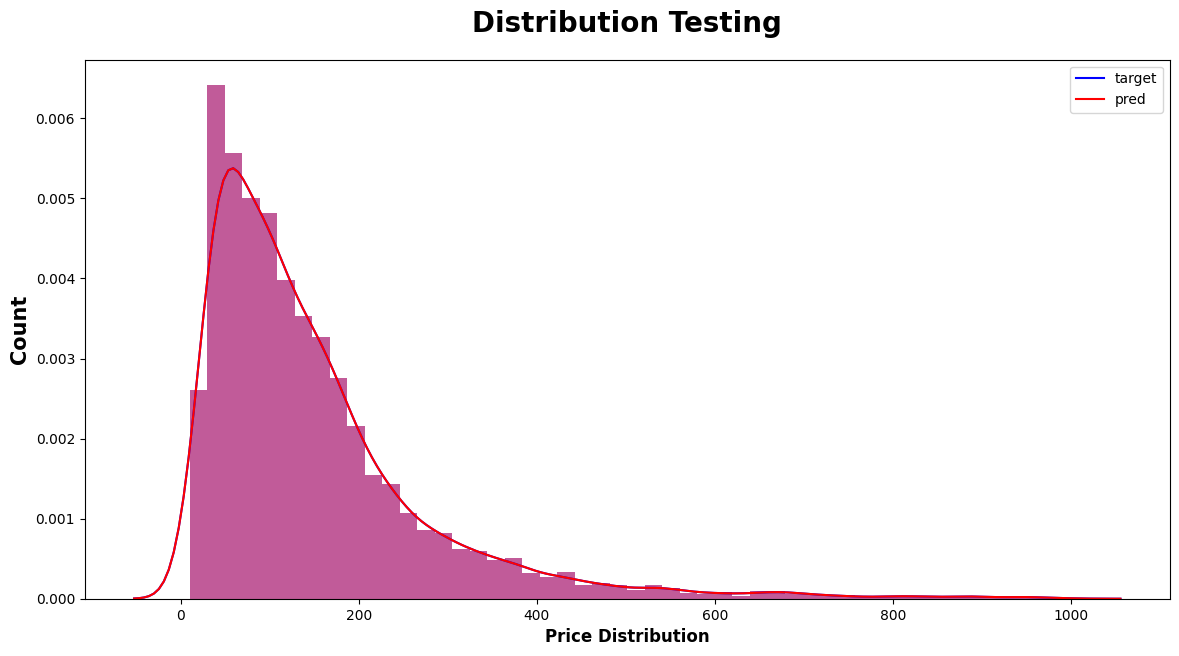

In [26]:


def plot_distribution():
    plt.subplots(figsize=(14,7))
    sns.distplot(x=pred_df['target'], color='blue', kde=True)
    sns.distplot(x=pred_df['pred'], color='red', kde=True)
    plt.title("Distribution Testing", weight="bold",fontsize=20, pad=20)
    plt.ylabel("Count", weight="bold", fontsize=15)
    plt.xlabel(f'Price Distribution', weight="bold", fontsize=12)
    plt.legend(['target', 'pred'])
    plt.show()
plot_distribution()

In [28]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)

gmm.fit(y_train.values.reshape(-1, 1))

pred_df = pd.DataFrame()
pred_df['target'] = y_train
pred_df['pred'] = gmm.predict(y_train.values.reshape(-1, 1))

/tmp/ipykernel_2192560/3116307612.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=pred_df['target'], color='blue', kde=True)
/tmp/ipykernel_2192560/3116307612.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=pred_df[pred_df['pred'] == 0]['target'], color='red', kde=True)
/tmp/ipykerne

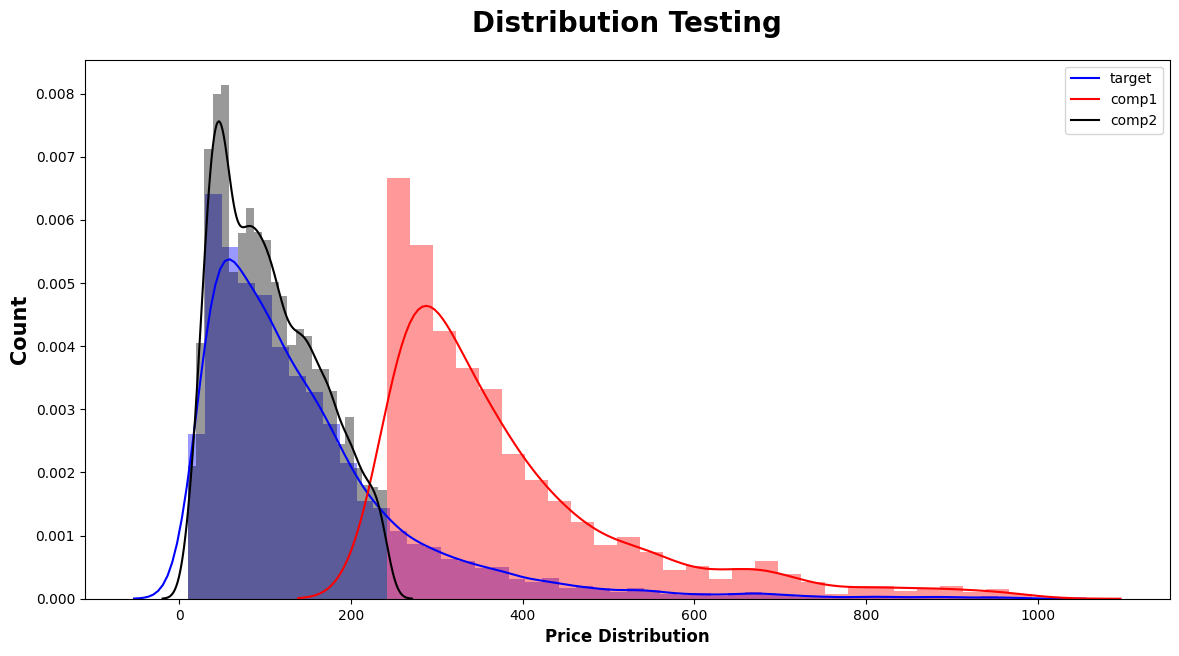

In [33]:
def plot_distribution():
    plt.subplots(figsize=(14,7))
    sns.distplot(x=pred_df['target'], color='blue', kde=True)
    sns.distplot(x=pred_df[pred_df['pred'] == 0]['target'], color='red', kde=True)
    sns.distplot(x=pred_df[pred_df['pred'] == 1]['target'], color='black', kde=True)

    plt.title("Distribution Testing", weight="bold",fontsize=20, pad=20)
    plt.ylabel("Count", weight="bold", fontsize=15)
    plt.xlabel(f'Price Distribution', weight="bold", fontsize=12)
    plt.legend(['target', 'comp1', 'comp2'])
    plt.show()
plot_distribution()